In [2]:
# --- Setup: Add project root to Python path ---
import sys, os

# Add project root to system path for local imports (if not already included)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# --- Import core modules for ChartAlignBench demo ---

# VLM model wrappers for inference (defined in utils/vlm_inference_helper.py)
# Default setup uses transformers==4.42.0
from utils.vlm_inference_helper import Phi35, LlaVa16, InternVL25   

# Alternative: Uncomment the Qwen model for evaluation
# Note: requires transformers >= 4.50.0
# from utils.qwen_inference_helper import Qwen25                    

# Predefined prompt templates used to query VLMs for specific grounding/alignment tasks
from utils.prompt_templates import PROMPT_TEMPLATES

# Utility functions for handling model inputs and outputs
from utils.process_vlm_io import process_pred_csv, get_chart_pair_images, data_alignment_str_to_json

# Evaluation functions for computing grounding and alignment metrics
from utils.evaluation_metrics import compute_grounding_metrics, compute_alignment_score

# Visualization utilities for displaying charts and results interactively
from utils.show_results import show_chart_grounding, show_chart_alignment


/cmlscratch/ani01/.conda/miniconda/envs/phi_3/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
from datasets import load_dataset

# dataset subset for performing Data Grounding & Alignment
dataset = load_dataset("umd-zhou-lab/ChartAlignBench", "data_grounding_and_alignment")["test"]

In [4]:
sample_idx = 1897

# select sample from dataset to perform the demo
sample = dataset[sample_idx]
sample

{'idx': 1897,
 'imgname': 'bar_209',
 'chart_type': 'bar_chart',
 'num_cell_difference': 2,
 'chart_1_grounding': 'State \t Number of Organizations \t Annual Donations (million) \n New York \t 100 \t 300 \n California \t 120 \t 400 \n Texas \t 110 \t 350 \n Florida \t 90 \t 380 \n ',
 'chart_2_grounding': 'State \t Number of Organizations \t Annual Donations (million) \n New York \t 157 \t 300 \n California \t 120 \t 400 \n Texas \t 52 \t 350 \n Florida \t 90 \t 380 \n ',
 'alignment_json': '{"0": {"row name": "Texas", "column name": "Number of Organizations", "value in chart 1": 110, "value in chart 2": 52}, "1": {"row name": "New York", "column name": "Number of Organizations", "value in chart 1": 100, "value in chart 2": 157}}',
 'image_pair': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2000x600>}

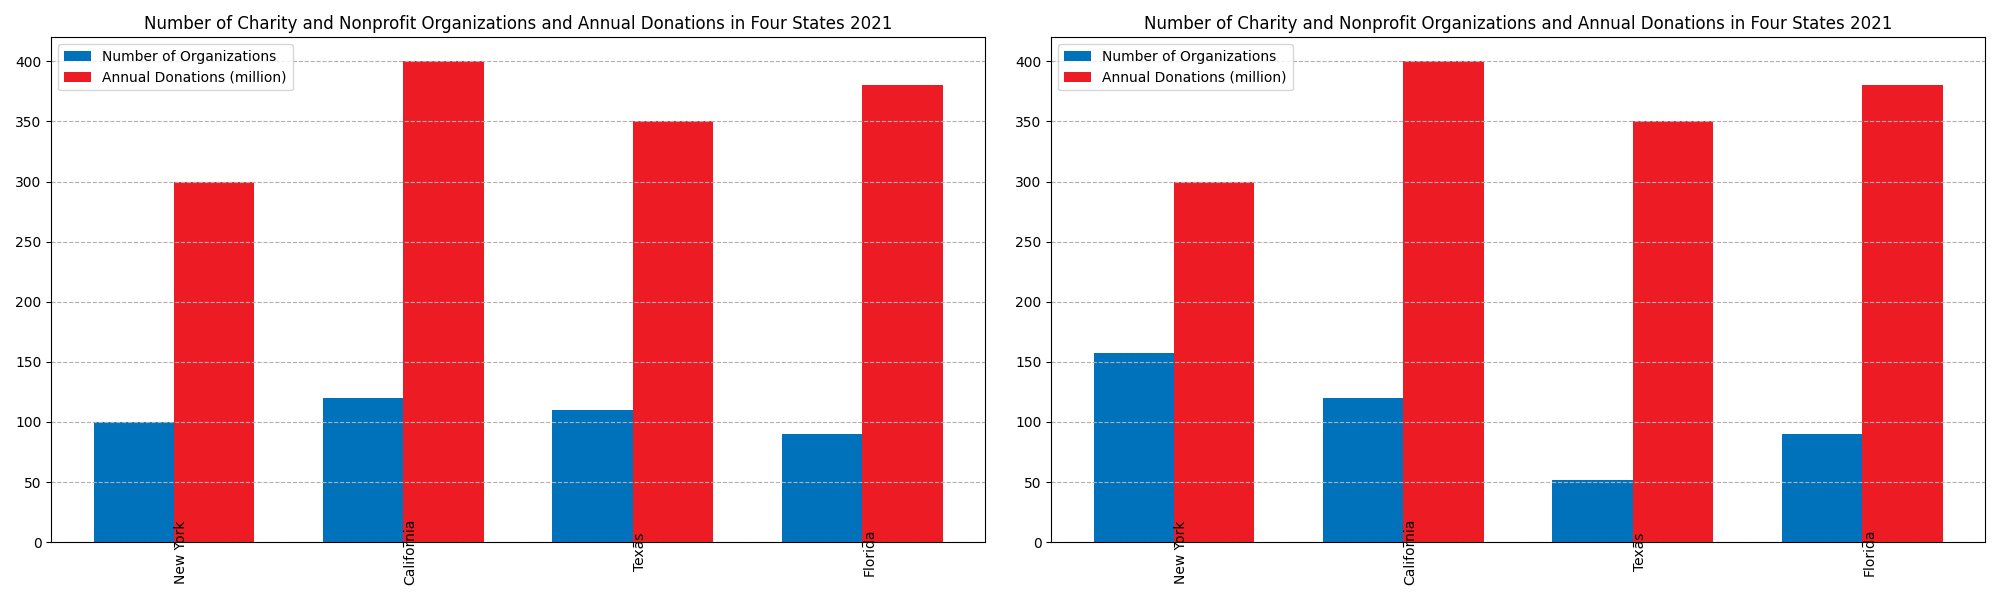

In [5]:
# image pair (pair of images stitched horizontally)
img = sample["image_pair"]

# individual chart images
chart_1_img, chart_2_img = get_chart_pair_images(img)
img

In [6]:
# unified model wrapper for inference (other models: LlaVa16, InternVL25, Qwen25, Qwen25 requires transformers >= 4.50.0)
VLM_obj = Phi35()

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- configuration_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- modeling_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/cmlscratch/ani01/.conda/miniconda/envs/phi_3/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:510: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Data Grounding

In this section, we evaluate VLMs ability to correctly ground *data* visualized by the chart.


In [7]:
# --- DATA Grounding Evaluation ---

# Retrieve the predefined prompt template for data grounding
data_grounding_prompt = PROMPT_TEMPLATES["data"]["grounding"]

# Grounding for Chart-1
chart_1_pred_grounding = process_pred_csv(
    VLM_obj.infer(
        prompt_text_template=data_grounding_prompt,  # query for grounding task
        images_list=[chart_1_img]                    # single chart input
    )
)

# Grounding for Chart-2
chart_2_pred_grounding = process_pred_csv(
    VLM_obj.infer(
        prompt_text_template=data_grounding_prompt,
        images_list=[chart_2_img]
    )
)

# Retrieve ground-truth grounding annotations for both charts
chart_1_gt_grounding = sample['chart_1_grounding']
chart_2_gt_grounding = sample['chart_2_grounding']

# Calculate data grounding score (CSV precision) 
chart_1_grounding_score = compute_grounding_metrics(chart_1_gt_grounding, chart_1_pred_grounding, "data")
chart_2_grounding_score = compute_grounding_metrics(chart_2_gt_grounding, chart_2_pred_grounding, "data")


The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


State,Number of Organizations,Annual Donations
New York,100,300
California,120,400
Texas,110,350
Florida,90,380
Category,Number of Organizations,Annual Donations
New York,120,300
California,115,350
Texas,110,320
Florida,105,360
State,Number of Organizations,Annual Donations

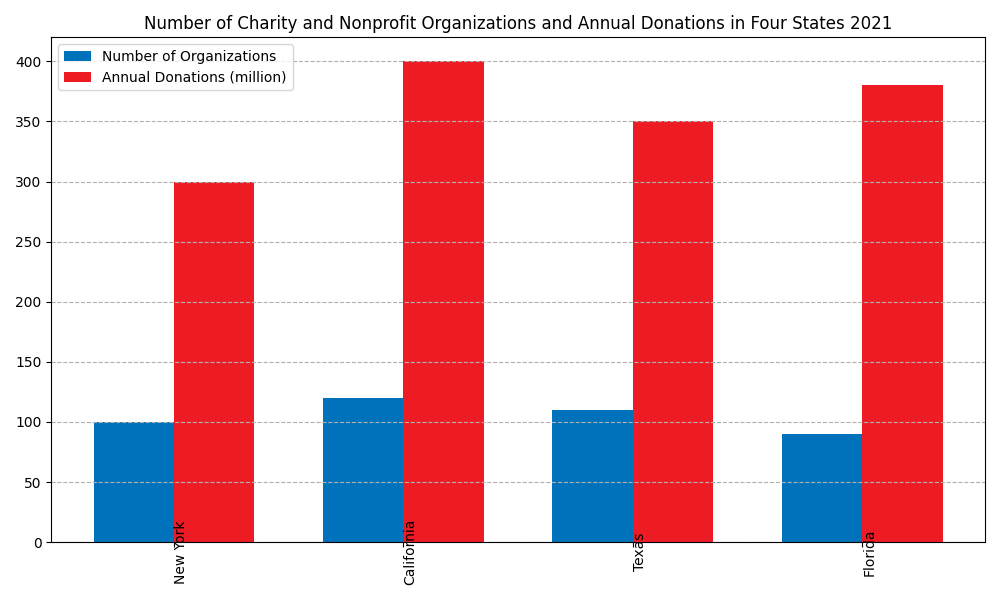
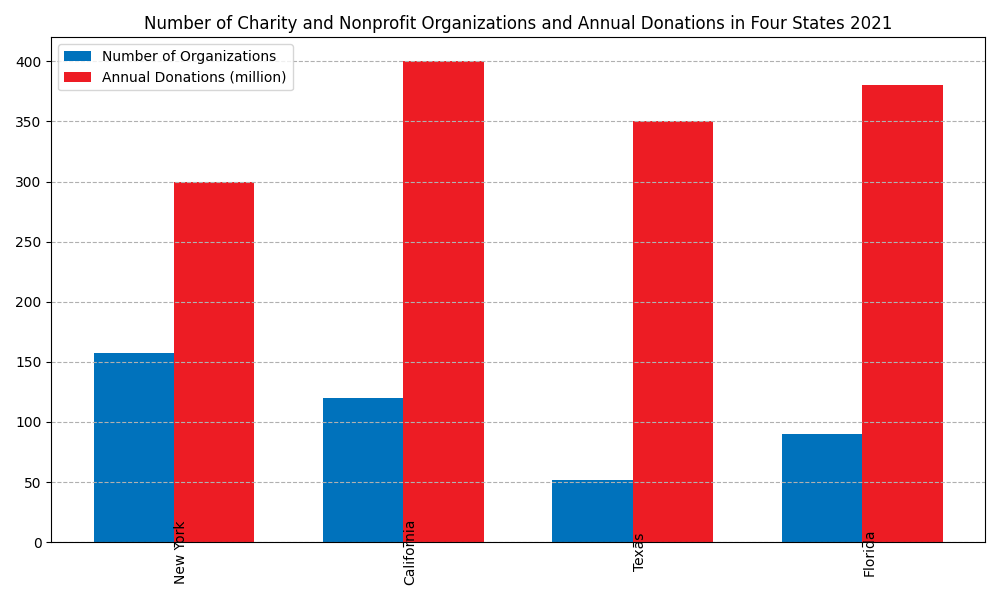

In [8]:
# --- Visualize grounding results ---

show_chart_grounding(
    chart_1_img,                # first chart image (e.g., reference chart)
    chart_2_img,                # second chart image (e.g., modified chart)
    chart_1_gt_grounding,       # ground-truth grounding annotations for chart 1
    chart_1_pred_grounding,     # model-predicted grounding for chart 1
    chart_2_gt_grounding,       # ground-truth grounding annotations for chart 2
    chart_2_pred_grounding,     # model-predicted grounding for chart 2
    chart_1_grounding_score,    # evaluation metric(s) for chart 1
    chart_2_grounding_score,    # evaluation metric(s) for chart 2
    content_type="data"         # type of grounding task ("data" for current notebook)
)


### Data Alignment

In this section, we evaluate VLMs **data alignment**, i.e., ability to find difference in data values between the chart image pair.

In [9]:
import json

# Retrieve the number of differing data cells between the two charts
num_cell_difference = sample["num_cell_difference"]

# Get the predefined alignment prompt template for data alignment
data_alignment_prompt = PROMPT_TEMPLATES["data"]["alignment"]

# Inject predicted grounding results of both charts into the alignment prompt
# These grounding results provide context for subsequent alignment of chart pair
data_alignment_prompt = data_alignment_prompt.replace(
    "image_1_predicted_grounding_tag", chart_1_pred_grounding
)
data_alignment_prompt = data_alignment_prompt.replace(
    "image_2_predicted_grounding_tag", chart_2_pred_grounding
)

# Insert the number of differing cells into the prompt for context
data_alignment_prompt = data_alignment_prompt.replace(
    "cells_change_cnt_tag", f"{num_cell_difference}"
)

# Adjust for singular/plural grammar in the prompt
if num_cell_difference == 1:
    data_alignment_prompt = data_alignment_prompt.replace("cell(s)", "cell")
else:
    data_alignment_prompt = data_alignment_prompt.replace("cell(s)", "cells")

# --- Run alignment inference and parse predictions ---

# Run inference with the constructed prompt and parse model output to JSON
pred_alignment_json = data_alignment_str_to_json(
    VLM_obj.infer(prompt_text_template=data_alignment_prompt),
    num_cell_difference
)

# Load the reference (ground-truth) alignment JSON from dataset
gt_alignment_json = json.loads(sample["alignment_json"])



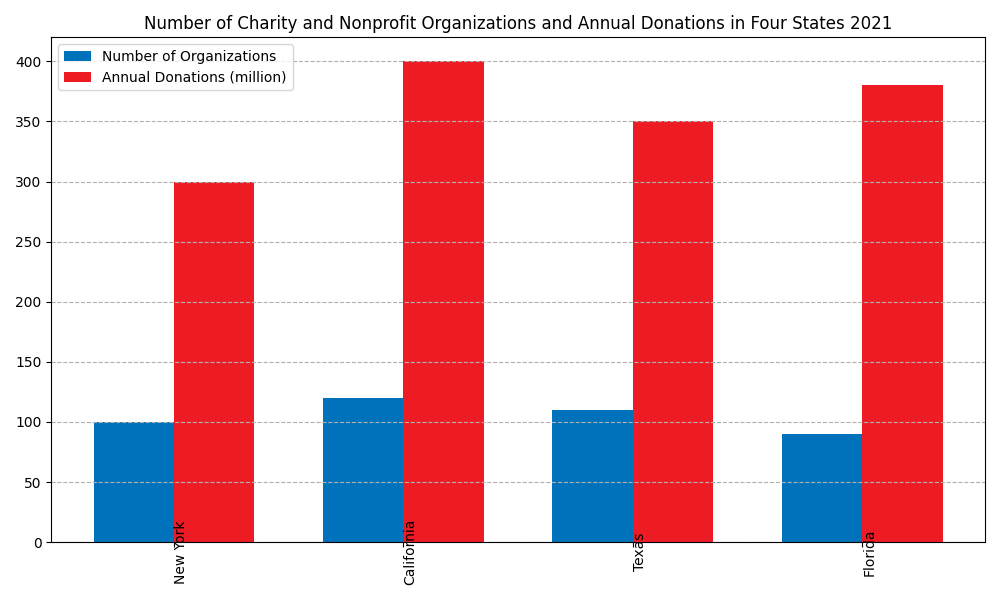
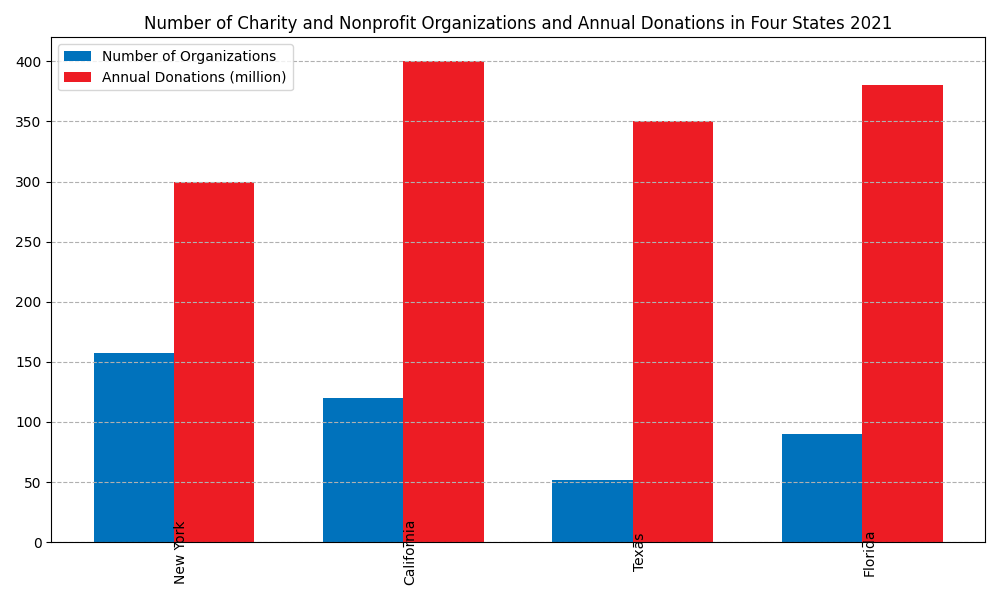

In [10]:
# --- Compute alignment score ---

# Precision of predicted v/s ground-truth JSON for the alignment task
alignment_score = compute_alignment_score(
    gt_alignment_json, pred_alignment_json, "data"
)

# --- Visualize alignment results ---

show_chart_alignment(
    chart_1_img,            # first chart image 
    chart_2_img,            # second chart image 
    gt_alignment_json,      # ground-truth alignment annotations
    pred_alignment_json,    # model-predicted alignment JSON
    alignment_score         # computed alignment metric(s)
)
